In [ ]:
!pip install catboost

In [ ]:
import pandas as pd
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import catboost
import datetime
from sklearn.model_selection import cross_val_score
from tqdm.notebook import tqdm
from sklearn.model_selection import KFold

from sklearn.ensemble import RandomForestClassifier
from google.colab import drive
drive.mount('/content/gdrive')
path = '/content/gdrive/MyDrive/idao_final'
import statsmodels.api as sm
import os
from collections import Counter
warnings.filterwarnings("ignore")



trxn_df = pd.read_csv(path + '/trxn.csv')
aum_df = pd.read_csv(path + '/aum.csv')
balance_df = pd.read_csv(path + '/balance.csv')
client_df = pd.read_csv(path + '/client.csv')
com_df = pd.read_csv(path + '/com.csv')
deals_df = pd.read_csv(path + '/deals.csv')
dict_mcc_df = pd.read_csv(path + '/dict_mcc.csv')
payments_df = pd.read_csv(path + '/payments.csv')
funnel_df = pd.read_csv(path + '/funnel.csv')

balance_df['month_end_dt'] = balance_df['month_end_dt'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
balance_df.drop_duplicates(inplace=True)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
def get_feature_zer():
    df = balance_df.drop_duplicates()
    d1 =  balance_df[['eop_bal_sum_rur', 'min_bal_sum_rur', 'max_bal_sum_rur','client_id', 'avg_bal_sum_rur']].groupby(by='client_id').\
                                    apply(lambda x: x.eop_bal_sum_rur.any() or x.min_bal_sum_rur.any() or x.max_bal_sum_rur.any() or x.avg_bal_sum_rur.any())
    d2 = balance_df[['eop_bal_sum_rur', 'min_bal_sum_rur', 'max_bal_sum_rur','client_id', 'avg_bal_sum_rur']].groupby(by='client_id').apply(lambda x: len(x))
    d3 = com_df[['client_id', 'prod']].groupby(by='client_id').apply(lambda x: Counter(x['prod']).most_common(1)[0][0])
    d4 = com_df[['client_id', 'prod']].groupby(by='client_id').apply(lambda x: Counter(x['prod']).most_common(1)[0][1])
    d5 = balance_df[['eop_bal_sum_rur', 'min_bal_sum_rur', 'max_bal_sum_rur','client_id', 'avg_bal_sum_rur']].groupby(by='client_id').apply(lambda x: x.var())
    return pd.concat((d1,d2,d3,d4,d5,client_df.set_index('client_id')[['gender','age','education']]), axis=1)



In [ ]:
def metrica(pred, amount, calls, const=4000.):
    amount[np.isnan(amount)] = 0
    return (pred*(amount - calls*const)).mean()

In [ ]:
def test_solver():
    X = get_feature_zer(path)
    y = funnel_df[['sale_flg', 'contacts', 'sale_amount']]
    iterations = range(700,800,100) 
    learning_rates = np.arange(0.02, 0.03, 0.01)
    # depths = np.arange(10,17,2,dtype=np.int16)
    result = []
    for iteration in tqdm(iterations):
        for learning_rate in tqdm(learning_rates):
            # for depth in tqdm(depths):
            cross_res = []
            kf = KFold(shuffle=True, n_splits=3)
            a_test = []
            for train_index, test_index in kf.split(X.index):

                X_train, X_test, y_train, y_test = X.iloc[train_index],X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
                cat = catboost.CatBoostClassifier(cat_features=[2, 'region_cd','education', 'gender'],iterations=iteration,
                                                  learning_rate= learning_rate)
                cat.fit(X_train ,y_train['sale_flg'], verbose=False, plot=True)

                proba = cat.predict_proba(X_test)
                max_res = 0
                max_tr = 0
                
                for tr in np.arange(0.8, 1.1, 0.01):
                    pred = np.ones(shape=(len(y_test)))
                    pred[np.where(proba[:,0]>tr)] = 0
                    tl = metrica(pred=pred, amount=y_test['sale_amount'].values, calls=y_test['contacts'].values)
                  
                    if tl > max_res:
                        max_res = tl
                        max_tr = tr
                print(max_tr)
                a_test.append(metrica(pred=np.ones(shape=(len(y_test),1)), amount=y_test['sale_amount'].values, calls=y_test['contacts'].values))

                # print('max_tr={}, max_res={}'.format(max_tr,max_res))
                cross_res.append(max_res)
            print('a_a_test={}'.format(np.mean(a_test)))
            result.append([np.mean(cross_res), learning_rate, iteration])
            print(max(result))
                  
          

In [ ]:
tmp = test_solver()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.8700000000000001


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.8


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.8300000000000001
a_a_test=2586.1902456042353
[5486.97443250535, 0.02, 700]




In [ ]:
train = get_feature_zer()
tmp = train.join(funnel_df.set_index('client_id'), how='right')

In [ ]:
X, y = tmp[tmp.columns[:12].tolist() + tmp.columns[15:].tolist()], tmp[['sale_flg', 'sale_amount', 'contacts']]
X.loc[X[2].isna(), 2] = "None"
X['education'].fillna('Other', inplace=True)
X['gender'].fillna('M', inplace=True)
X['region_cd'] = X['region_cd'].apply(lambda x: str(x))
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
X = X[[ 0, 1, 2,
3, 'eop_bal_sum_rur', 'min_bal_sum_rur',
'max_bal_sum_rur', 'avg_bal_sum_rur', 'feature_1',
'client_segment', 'feature_2', 'feature_3',
'feature_4', 'feature_5', 'feature_6',
'feature_7', 'feature_8', 'feature_9',
'feature_10', 'region_cd', 'gender',
'age', 'education']] 

In [ ]:
cat = catboost.CatBoostClassifier(cat_features=[2, 'region_cd','education', 'gender'],iterations=700,
                                                  learning_rate= 0.02)
cat.fit(X, y['sale_flg'], verbose=True, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6533407	total: 72.2ms	remaining: 50.4s
1:	learn: 0.6186678	total: 152ms	remaining: 53.1s
2:	learn: 0.5848671	total: 206ms	remaining: 48s
3:	learn: 0.5545837	total: 246ms	remaining: 42.9s
4:	learn: 0.5259237	total: 287ms	remaining: 39.9s
5:	learn: 0.5037213	total: 327ms	remaining: 37.8s
6:	learn: 0.4818581	total: 364ms	remaining: 36s
7:	learn: 0.4618003	total: 427ms	remaining: 36.9s
8:	learn: 0.4440717	total: 481ms	remaining: 37s
9:	learn: 0.4290357	total: 526ms	remaining: 36.3s
10:	learn: 0.4142956	total: 563ms	remaining: 35.2s
11:	learn: 0.4005148	total: 596ms	remaining: 34.2s
12:	learn: 0.3877490	total: 626ms	remaining: 33.1s
13:	learn: 0.3767054	total: 663ms	remaining: 32.5s
14:	learn: 0.3666749	total: 703ms	remaining: 32.1s
15:	learn: 0.3624135	total: 749ms	remaining: 32s
16:	learn: 0.3583326	total: 784ms	remaining: 31.5s
17:	learn: 0.3498304	total: 816ms	remaining: 30.9s
18:	learn: 0.3423306	total: 851ms	remaining: 30.5s
19:	learn: 0.3352299	total: 884ms	remaining: 30.

In [ ]:
# with open('my_model.joblib', 'w') as f:
joblib.dump(cat, 'my_model_b.joblib')

['my_model_b.joblib']

In [ ]:
# cat = joblib.load('my_model.joblib')

In [ ]:
def get_feature_zer(path):
    balance_df = pd.read_csv(path + '/balance.csv')
    client_df = pd.read_csv(path + '/client.csv')
    com_df = pd.read_csv(path + '/com.csv')
    funnel_df = pd.read_csv(path + '/funnel.csv')
    # balance_df['month_end_dt'] = balance_df['month_end_dt'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
    # balance_df.drop_duplicates(inplace=True)
    df = balance_df.drop_duplicates()
    d1 =  balance_df[['eop_bal_sum_rur', 'min_bal_sum_rur', 'max_bal_sum_rur','client_id', 'avg_bal_sum_rur']].groupby(by='client_id').\
                                    apply(lambda x: x.eop_bal_sum_rur.any() or x.min_bal_sum_rur.any() or x.max_bal_sum_rur.any() or x.avg_bal_sum_rur.any())
    d2 = balance_df[['eop_bal_sum_rur', 'min_bal_sum_rur', 'max_bal_sum_rur','client_id', 'avg_bal_sum_rur']].groupby(by='client_id').apply(lambda x: len(x))
    d3 = com_df[['client_id', 'prod']].groupby(by='client_id').apply(lambda x: Counter(x['prod']).most_common(1)[0][0])
    d4 = com_df[['client_id', 'prod']].groupby(by='client_id').apply(lambda x: Counter(x['prod']).most_common(1)[0][1])
    d5 = balance_df[['eop_bal_sum_rur', 'min_bal_sum_rur', 'max_bal_sum_rur','client_id', 'avg_bal_sum_rur']].groupby(by='client_id').apply(lambda x: x.var())
    train =  pd.concat((d1,d2,d3,d4,d5,client_df.set_index('client_id')[['gender','age','education']]), axis=1)
    f = funnel_df.drop(['sale_flg', 'sale_amount', 'contacts'], axis=1).set_index('client_id')
    tmp = train.join(f, how='right')
    X = tmp
    X.loc[X[2].isna(), 2] = "None"
    X['education'].fillna('Other', inplace=True)
    X['gender'].fillna('M', inplace=True)
    X['region_cd'] = X['region_cd'].apply(lambda x: str(x))
    return X.drop('client_id', axis=1)
cat = joblib.load('my_models.joblib')
X = get_feature_zer(path)
X = X[[ 0, 1, 2,
3, 'eop_bal_sum_rur', 'min_bal_sum_rur',
'max_bal_sum_rur', 'avg_bal_sum_rur', 'feature_1',
'client_segment', 'feature_2', 'feature_3',
'feature_4', 'feature_5', 'feature_6',
'feature_7', 'feature_8', 'feature_9',
'feature_10', 'region_cd', 'gender',
'age', 'education']] 
proba = cat.predict_proba(X)
pred = np.ones(shape=(len(X)))
pred[np.where(proba[:,0]>0.985)] = 0

In [ ]:
# proba = cat.predict_proba(X)
# pred = np.ones(shape=(len(y)))
# pred[np.where(proba[:,0]>0.99)] = 0
# tl = metrica(pred=pred, amount=funnel_df['sale_amount'].values, calls=funnel_df['contacts'].values)

## Бизнес сегменты по предложениям

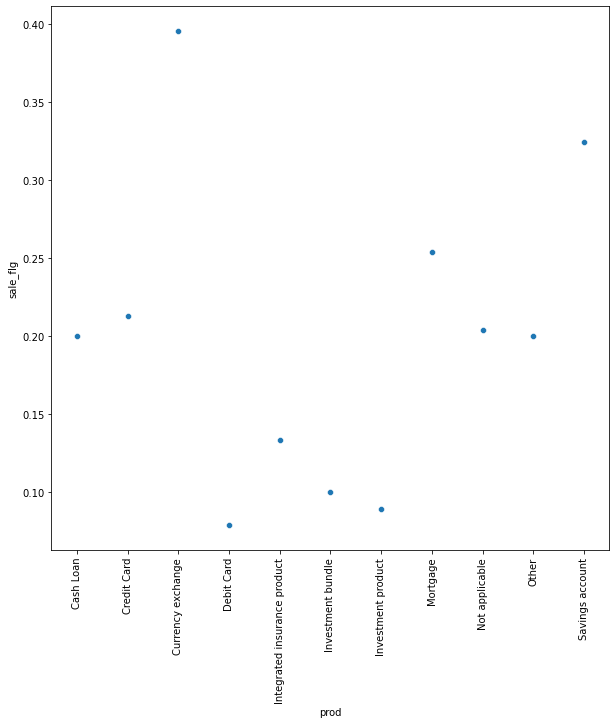

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
tmp = com_df.join(funnel_df.set_index('client_id'),on='client_id')[['sale_flg','prod']].\
                                    groupby(by='prod',as_index=False).mean()
g = sns.scatterplot(data=tmp, x="prod", y="sale_flg")
g.set_xticklabels(rotation=90, labels=tmp['prod'].unique())
plt.show()

## Бутсрапленые средние по продуктам

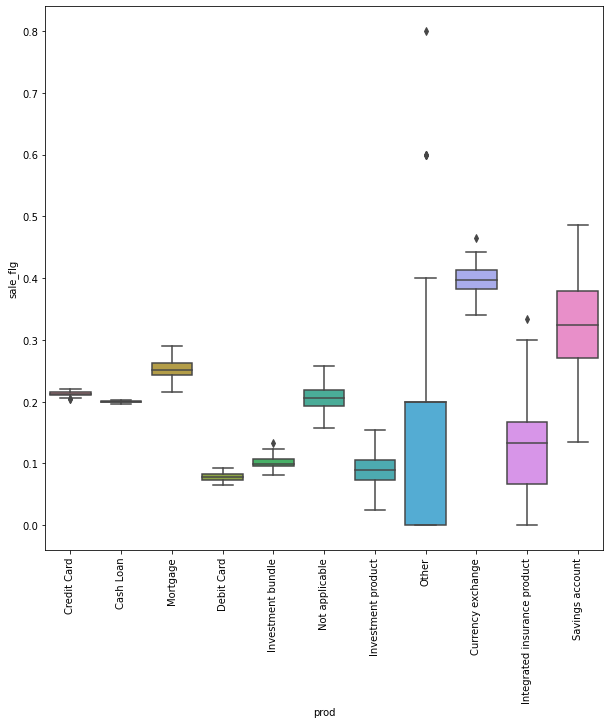

In [ ]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples
tmp = com_df.join(funnel_df.set_index('client_id'),on='client_id')[['sale_flg','prod']]
data = []
for col in tmp['prod'].unique():
    val = tmp.loc[tmp['prod']==col,'sale_flg'].values
    boot = get_bootstrap_samples(val,100).mean(axis = 1)
    for m in boot:
        data.append([col,m])
boot_df = pd.DataFrame(data=data,columns=['prod','sale_flg']).dropna()
fig,ax = plt.subplots(1,1,figsize=(10,10))
g = sns.boxplot(x="prod", y="sale_flg", data=boot_df, ax=ax)
g.set_xticklabels(rotation=90, labels=boot_df['prod'].unique())
plt.show()

## Сегменты с согласиями

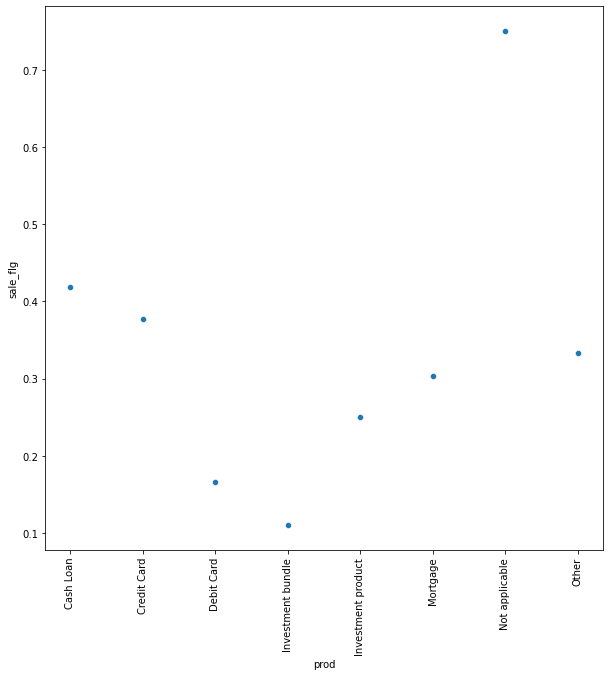

In [ ]:
tmp_com = com_df[com_df.agr_flg == True]
tmp = tmp_com.join(funnel_df.set_index("client_id"), on='client_id').groupby(by='prod',as_index=False).mean()
fig,ax = plt.subplots(1,1,figsize=(10,10))
g = sns.scatterplot(data=tmp, x="prod", y="sale_flg")
g.set_xticklabels(rotation=90, labels=tmp['prod'].unique())
plt.show()

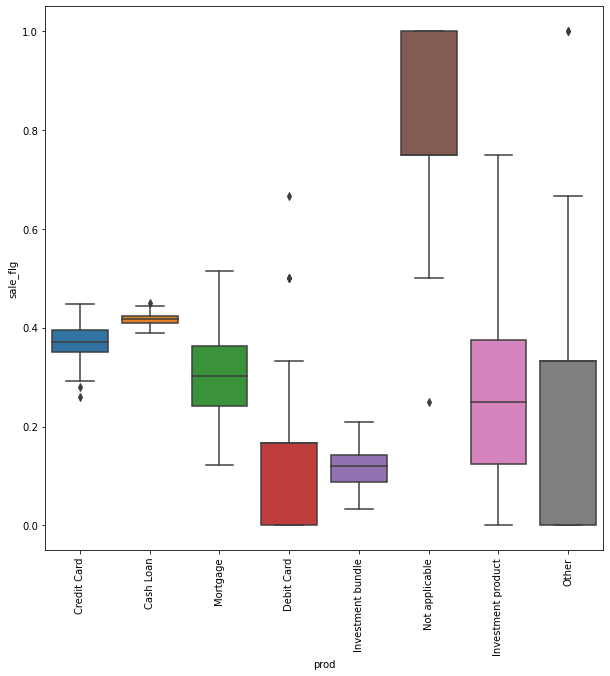

In [ ]:
tmp = tmp_com.join(funnel_df.set_index("client_id"), on='client_id')
data = []
for col in tmp['prod'].unique():
    val = tmp.loc[tmp['prod']==col,'sale_flg'].values
    boot = get_bootstrap_samples(val,100).mean(axis = 1)
    for m in boot:
        data.append([col,m])
boot_df = pd.DataFrame(data=data,columns=['prod','sale_flg']).dropna()
fig,ax = plt.subplots(1,1,figsize=(10,10))
g = sns.boxplot(x="prod", y="sale_flg", data=boot_df, ax=ax)
g.set_xticklabels(rotation=90, labels=boot_df['prod'].unique())
plt.show()

## Сегменты с отказами

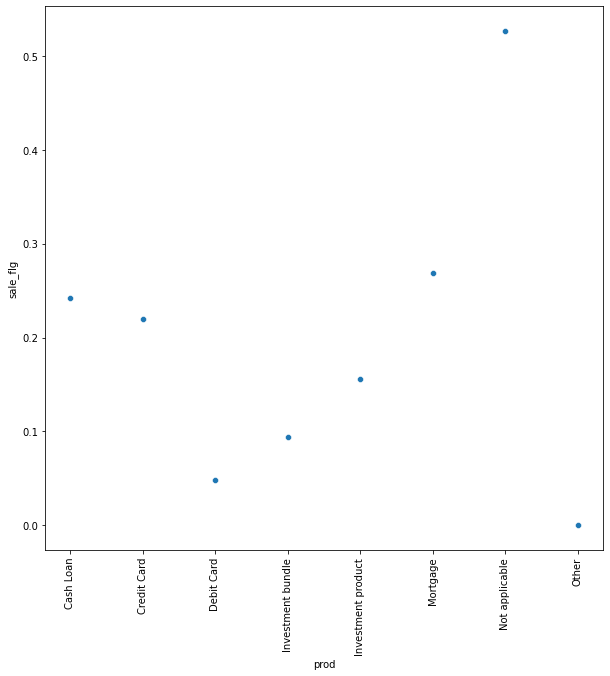

In [ ]:
tmp_com = com_df[com_df.otkaz == True]
tmp = tmp_com.join(funnel_df.set_index("client_id"), on='client_id').groupby(by='prod',as_index=False).mean()
fig,ax = plt.subplots(1,1,figsize=(10,10))
g = sns.scatterplot(data=tmp, x="prod", y="sale_flg")
g.set_xticklabels(rotation=90, labels=tmp['prod'].unique())
plt.show()

In [ ]:
tmp_com = com_df[com_df.otkaz == True]
l_m = tmp_com['prod'].value_counts()
means = com_df['prod'].value_counts()

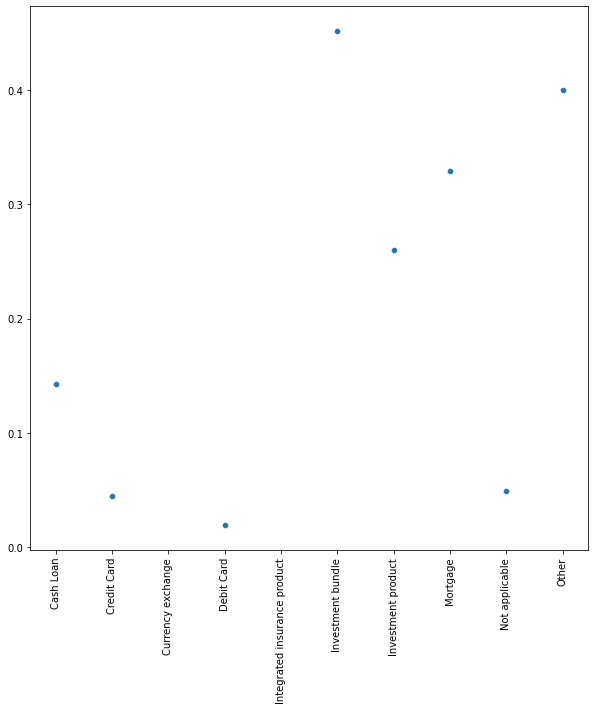

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(10,10))

g = sns.scatterplot(x = (l_m/means).index, y = (l_m/means).values)
g.set_xticklabels(rotation=90, labels=(l_m/means).index)
plt.show()

## Сегменты по клиентам

<AxesSubplot:xlabel='client_segment', ylabel='sale_flg'>

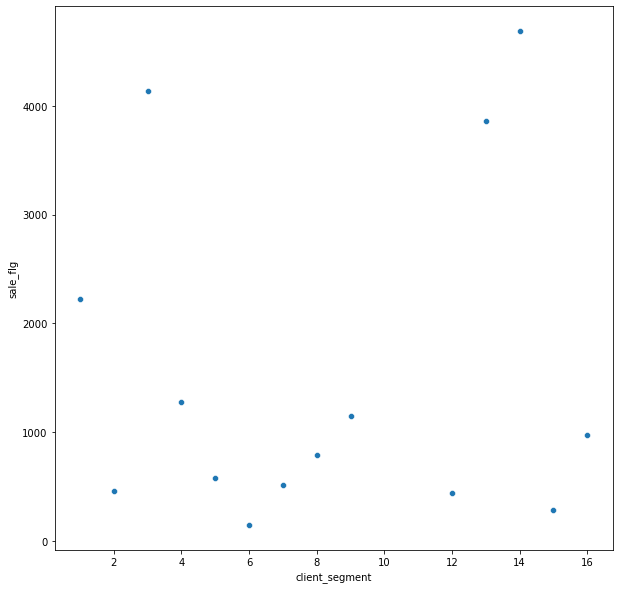

In [ ]:
tmp = funnel_df[['client_segment','sale_flg']].groupby(by='client_segment',as_index=False).count()
fig,ax = plt.subplots(1,1,figsize=(10,10))

sns.scatterplot(data=tmp, x="client_segment", y="sale_flg")

## Бутсрапленые средние по сегментам

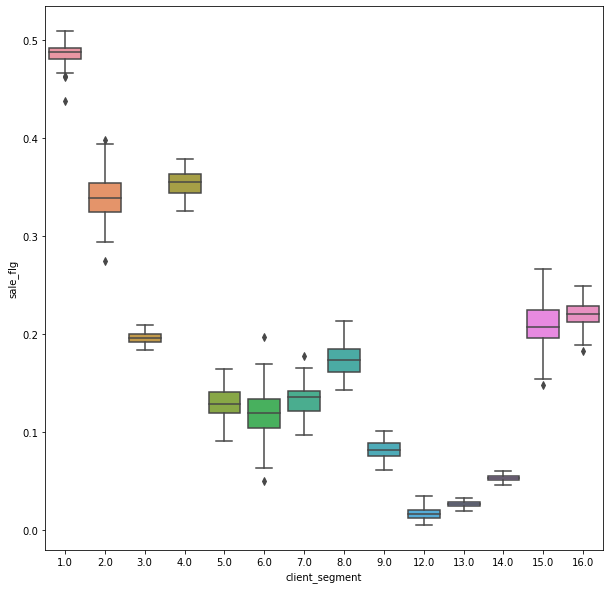

In [ ]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples
data = []
tmp = funnel_df[['client_segment','sale_flg']]
for col in tmp['client_segment'].unique():
    val = tmp.loc[tmp['client_segment']==col,'sale_flg'].values
    boot = get_bootstrap_samples(val,100).mean(axis = 1)
    for m in boot:
        data.append([col,m])
boot_df = pd.DataFrame(data=data,columns=['client_segment','sale_flg']).dropna()
fig,ax = plt.subplots(1,1,figsize=(10,10))
g = sns.boxplot(x="client_segment", y="sale_flg", data=boot_df, ax=ax)
# g.set_xticklabels(rotation=90, labels=boot_df['prod'].unique())
plt.show()

## Возраст

<AxesSubplot:xlabel='age', ylabel='sale_flg'>

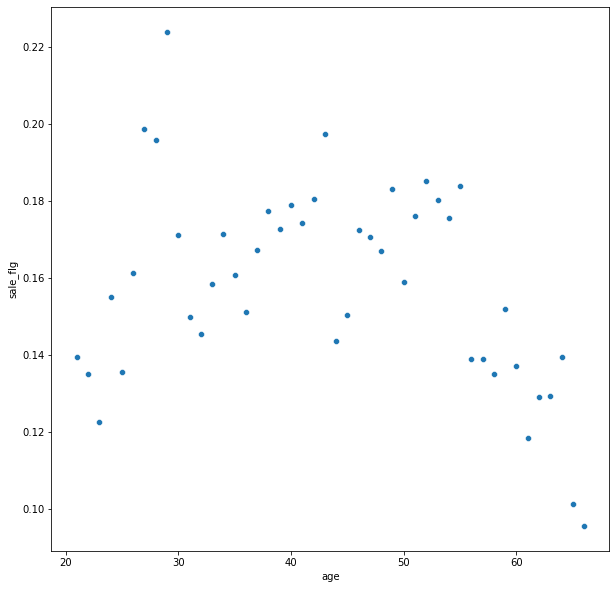

In [ ]:
tmp = funnel_df.join(client_df.set_index('client_id'),on='client_id')[['sale_flg','age']].\
                                    groupby(by='age',as_index=False).mean()
fig,ax = plt.subplots(1,1,figsize=(10,10))

sns.scatterplot(data=tmp, x="age", y="sale_flg")

<AxesSubplot:xlabel='age', ylabel='Count'>

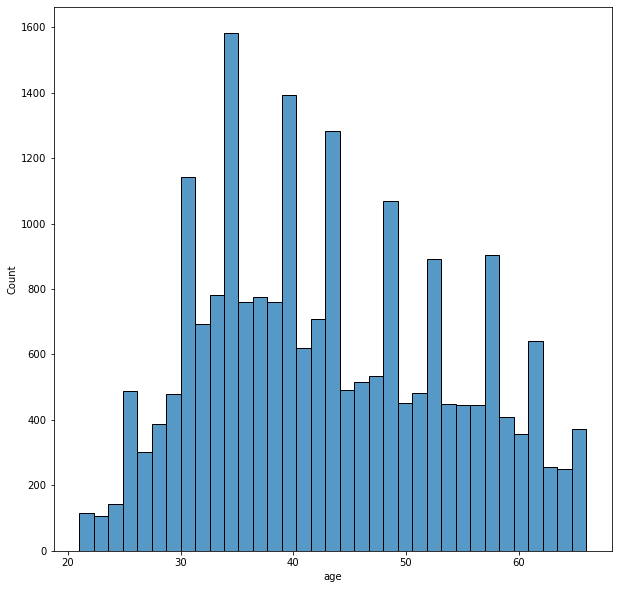

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
ax.set_title()
sns.histplot(data=client_df, x="age")

In [ ]:
age_arr = np.arange(client_df.age.min(), client_df.age.max() + 1, dtype = np.int32)
age_arrs = np.array_split(age_arr, age_arr.size/2)

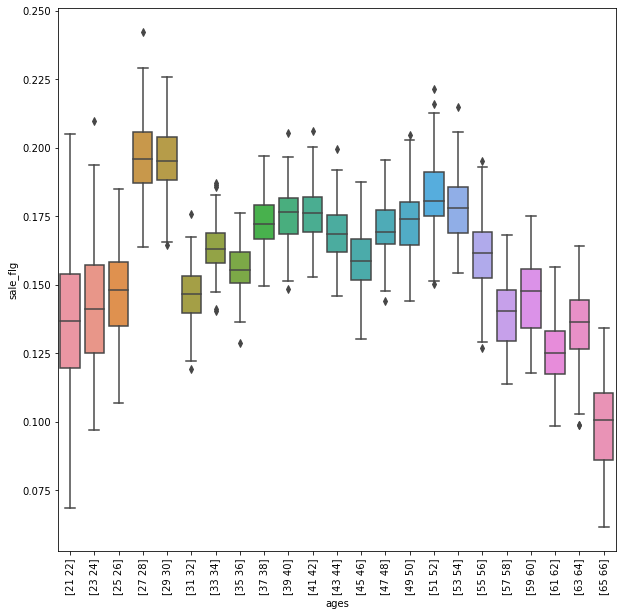

In [ ]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

data = []
tmp = funnel_df.join(client_df.set_index('client_id'),on='client_id')[['sale_flg','age']]
for ages in age_arrs:
    val = tmp.loc[tmp['age'].isin(ages),'sale_flg'].values
    boot = get_bootstrap_samples(val,100).mean(axis = 1)
    for m in boot:
        data.append([str(ages),m])
boot_df = pd.DataFrame(data=data,columns=['ages','sale_flg']).dropna()

fig,ax = plt.subplots(1,1,figsize=(10,10))
g = sns.boxplot(x="ages", y="sale_flg", data=boot_df, ax=ax)
g.set_xticklabels(rotation=90, labels=boot_df['ages'].unique())
plt.show()

## Гендер

<AxesSubplot:xlabel='gender', ylabel='sale_flg'>

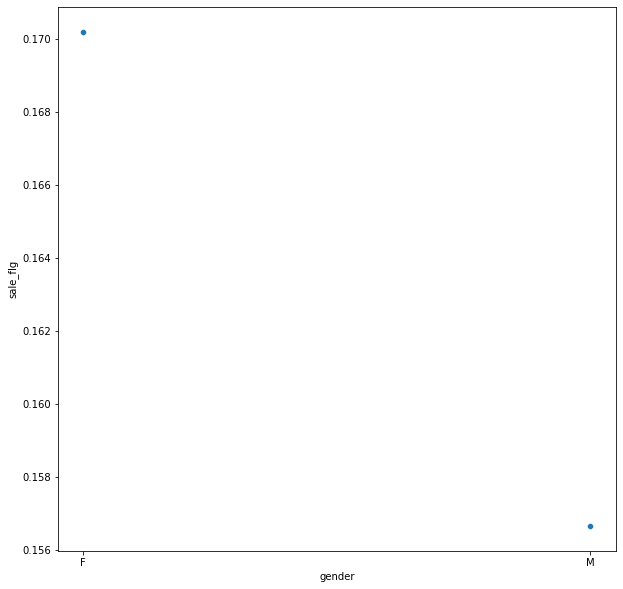

In [ ]:
tmp = funnel_df.join(client_df.set_index('client_id'),on='client_id')[['sale_flg','gender']].\
                                    groupby(by='gender',as_index=False).mean()
fig,ax = plt.subplots(1,1,figsize=(10,10))

sns.scatterplot(data=tmp, x="gender", y="sale_flg")

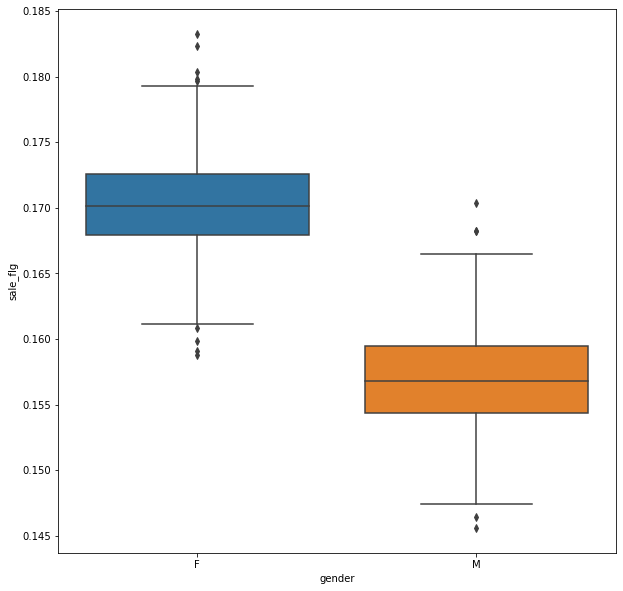

In [ ]:
data = []
tmp = tmp = funnel_df.join(client_df.set_index('client_id'),on='client_id')[['sale_flg','gender']]
for col in tmp['gender'].unique():
    val = tmp.loc[tmp['gender']==col,'sale_flg'].values
    boot = get_bootstrap_samples(val,1000).mean(axis = 1)
    for m in boot:
        data.append([col,m])
boot_df = pd.DataFrame(data=data,columns=['gender','sale_flg']).dropna()
fig,ax = plt.subplots(1,1,figsize=(10,10))
g = sns.boxplot(x="gender", y="sale_flg", data=boot_df, ax=ax)
# g.set_xticklabels(rotation=90, labels=boot_df['prod'].unique())
plt.show()

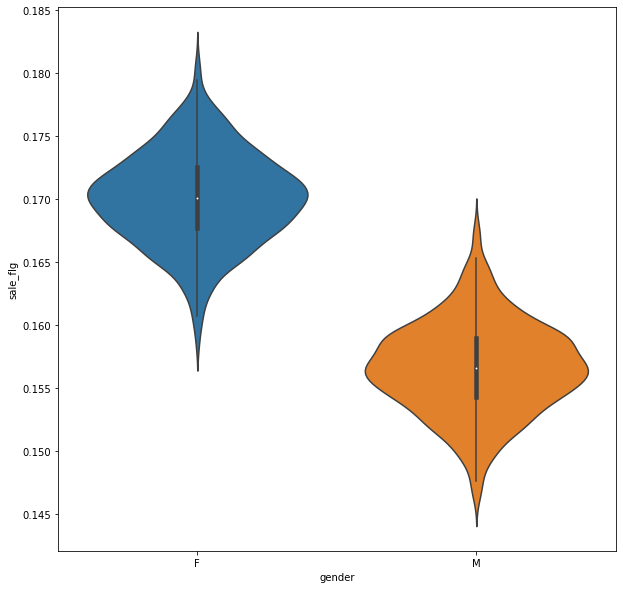

In [ ]:
data = []
tmp = tmp = funnel_df.join(client_df.set_index('client_id'),on='client_id')[['sale_flg','gender']]
for col in tmp['gender'].unique():
    val = tmp.loc[tmp['gender']==col,'sale_flg'].values
    boot = get_bootstrap_samples(val,1000).mean(axis = 1)
    for m in boot:
        data.append([col,m])
boot_df = pd.DataFrame(data=data,columns=['gender','sale_flg']).dropna()
fig,ax = plt.subplots(1,1,figsize=(10,10))
g = sns.violinplot(x="gender", y="sale_flg", data=boot_df, ax=ax)
# g.set_xticklabels(rotation=90, labels=boot_df['prod'].unique())
plt.show()

## Edu

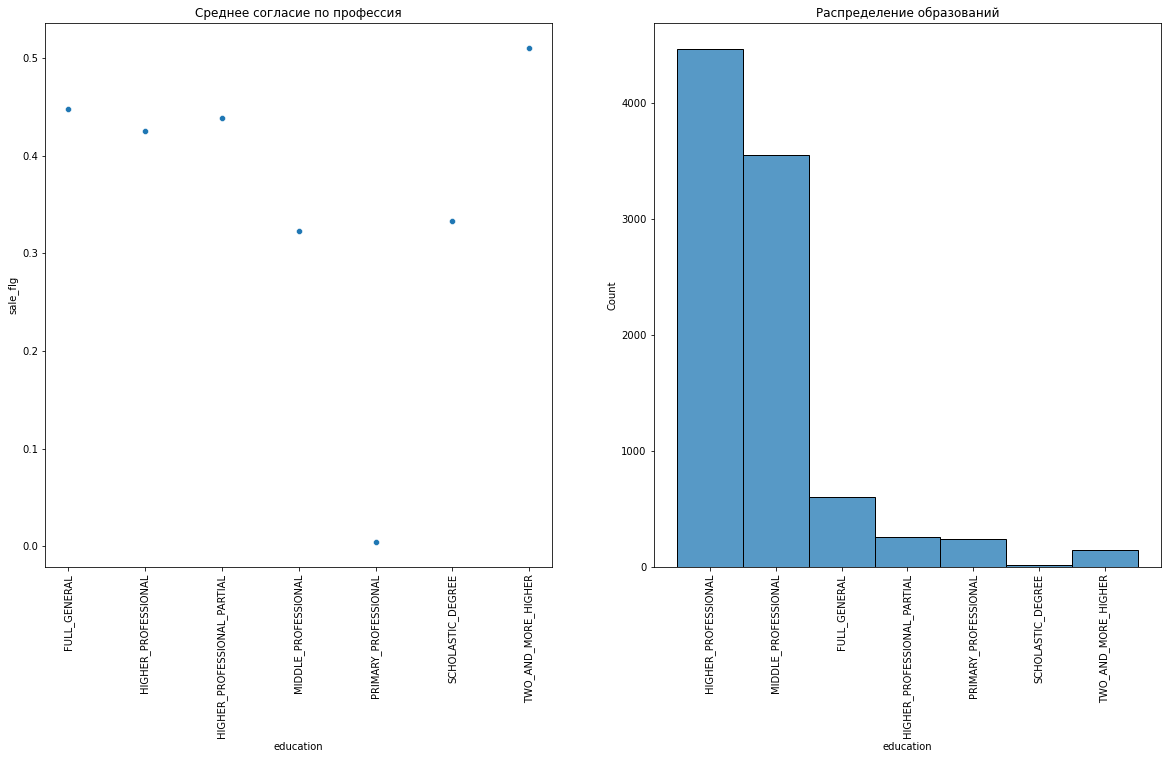

In [ ]:
tmp = funnel_df.join(client_df.set_index('client_id'),on='client_id')[['sale_flg','education']].\
                                    groupby(by='education',as_index=False).mean()
fig,ax = plt.subplots(1,2,figsize=(20,10))
ax[0].set_title('Среднее согласие по профессия')
g = sns.scatterplot(data=tmp.dropna(), x="education", y="sale_flg",ax = ax[0])
g.set_xticklabels(rotation=90, labels=tmp['education'].unique())
tmp = funnel_df.join(client_df.set_index('client_id'),on='client_id')[['sale_flg','education']]
ax[1].set_title('Распределение образований')
g = sns.histplot(data=tmp["education"].dropna(), ax = ax[1])
g.set_xticklabels(rotation=90, labels=tmp['education'].dropna().unique())
plt.show()

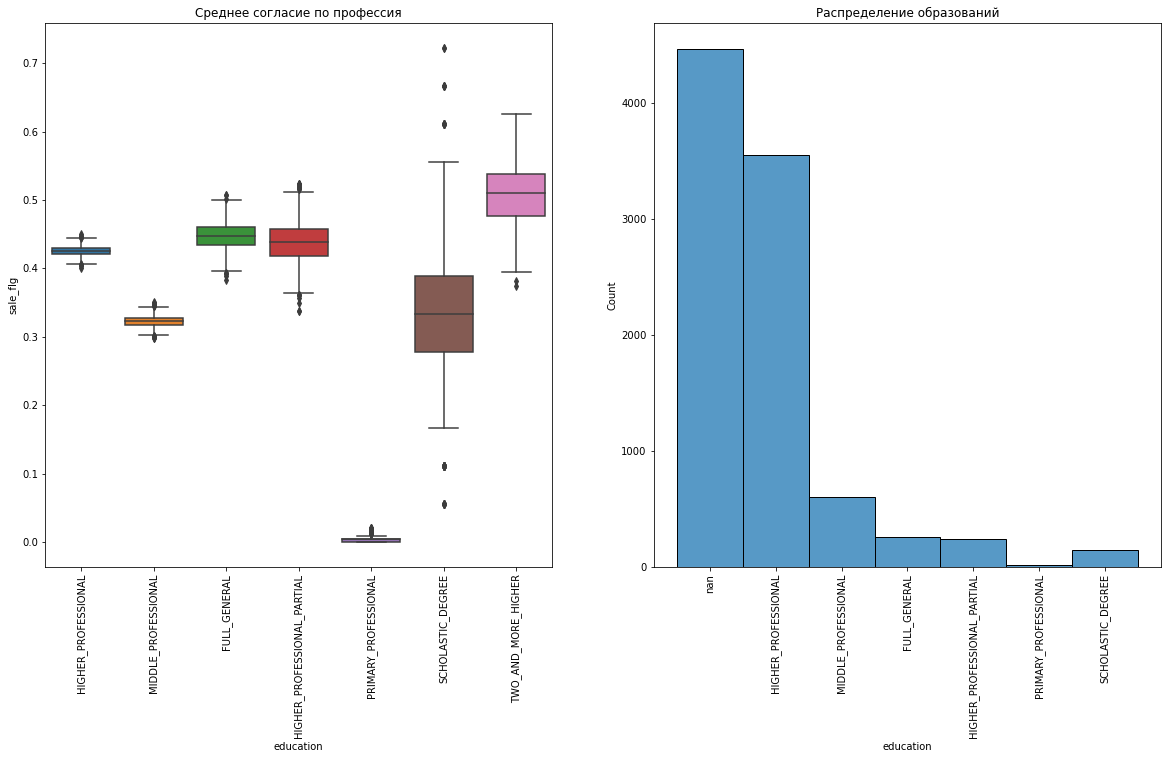

In [ ]:
tmp = funnel_df.join(client_df.set_index('client_id'),on='client_id')[['sale_flg','education']]
#                                     groupby(by='education',as_index=False)#.mean()
data = []
# tmp = tmp = funnel_df.join(client_df.set_index('client_id'),on='client_id')[['sale_flg','gender']]

for col in tmp['education'].unique():
    val = tmp.loc[tmp['education']==col,'sale_flg'].values
    boot = get_bootstrap_samples(val,1000).mean(axis = 1)
    for m in boot:
        data.append([col,m])
boot_df = pd.DataFrame(data=data,columns=['education','sale_flg']).dropna()
fig,ax = plt.subplots(1,2,figsize=(20,10))
ax[0].set_title('Среднее согласие по профессия')
g = sns.boxplot(x="education", y="sale_flg", data=boot_df, ax=ax[0],)
g.set_xticklabels(rotation=90, labels=boot_df['education'].unique())
tmp = funnel_df.join(client_df.set_index('client_id'),on='client_id')[['sale_flg','education']]
ax[1].set_title('Распределение образований')
g = sns.histplot(data=tmp["education"].dropna(), ax = ax[1])
g.set_xticklabels(rotation=90, labels=tmp['education'].unique())
plt.show()

## Анализ баланса

In [ ]:
balance_df['month_end_dt'] = balance_df['month_end_dt'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

In [ ]:
def get_time_arr(df,client_id):
    tmp = df[df.client_id == client_id]
    first_d = tmp.month_end_dt.min()
    sec_d = tmp.month_end_dt.max()
    months_range = sec_d.year*12 + sec_d.month - first_d.year*12 + first_d.month
    dates = []
    current_month = first_d.month
    current_year = first_d.year
    for i in range(months_range):
        d1 = datetime.datetime(current_year,current_month,1)
        if current_month == 12:
            current_year += 1
            current_month = 1
        else:
            current_month+=1
        d2 = datetime.datetime(current_year,current_month,1)
        dates.append([d1,d2])
    return dates

def get_time_series(df, client_id, feature_name, funk = np.mean):
    # arr_time = get_time_arr(df=df, client_id=client_id)
    tmp = df[df.client_id == client_id]
    first_d = tmp.month_end_dt.min()
    sec_d = tmp.month_end_dt.max()
    months_range = sec_d.year*12 + sec_d.month - first_d.year*12 + first_d.month
    current_month = first_d.month
    current_year = first_d.year
    data = []
    for i in range(months_range):
        d1 = datetime.datetime(current_year,current_month,1)
        if current_month == 12:
            current_year += 1
            current_month = 1
        else:
            current_month+=1
        d2 = datetime.datetime(current_year,current_month,1)
        res = tmp[(tmp.month_end_dt >= d1)*(tmp.month_end_dt < d2)][feature_name]
        data.append([datetime.datetime(d1.year, d1.month,1), funk(res)])
    return pd.DataFrame(data=data,
                        columns=['date','series'])

def create_features_from_series(df, client_id, feature_name, funk = np.mean):
    tmp = get_time_series(balance_df, client_id, feature_name, np.mean).dropna()
    res =  (tmp.series.shift(-1).dropna().values - tmp.series.values[:-1]).mean() or 0
    proc = len(tmp[tmp.series>0])/len(tmp) or 0
    m = np.median(tmp.series) or 0
    var = np.var(tmp.series) or 0
    val = m/(var +0.001) or 0
    return [res,proc,m,var,val]
def test_feature(df, N, feature_name, funk = np.median):
    # idx = np.random.choice(df.client_id.values, N)
    idx = df.client_id.unique()
    X = np.zeros(shape=(idx.size, 5))
    y = np.zeros(shape=(idx.size, ))
    for i, index in tqdm(enumerate(idx)):
        l =  create_features_from_series(df, index, feature_name, funk)
        if None in l:
            print('Hello')
        X[i,:] = l
        y[i] = funnel_df.loc[funnel_df.client_id == index, 'sale_flg']
    return idx, X, y

In [ ]:
client_df.gender.value_counts()

F    11116
M    10379
Name: gender, dtype: int64

In [ ]:
np.unique(idx).size

8593

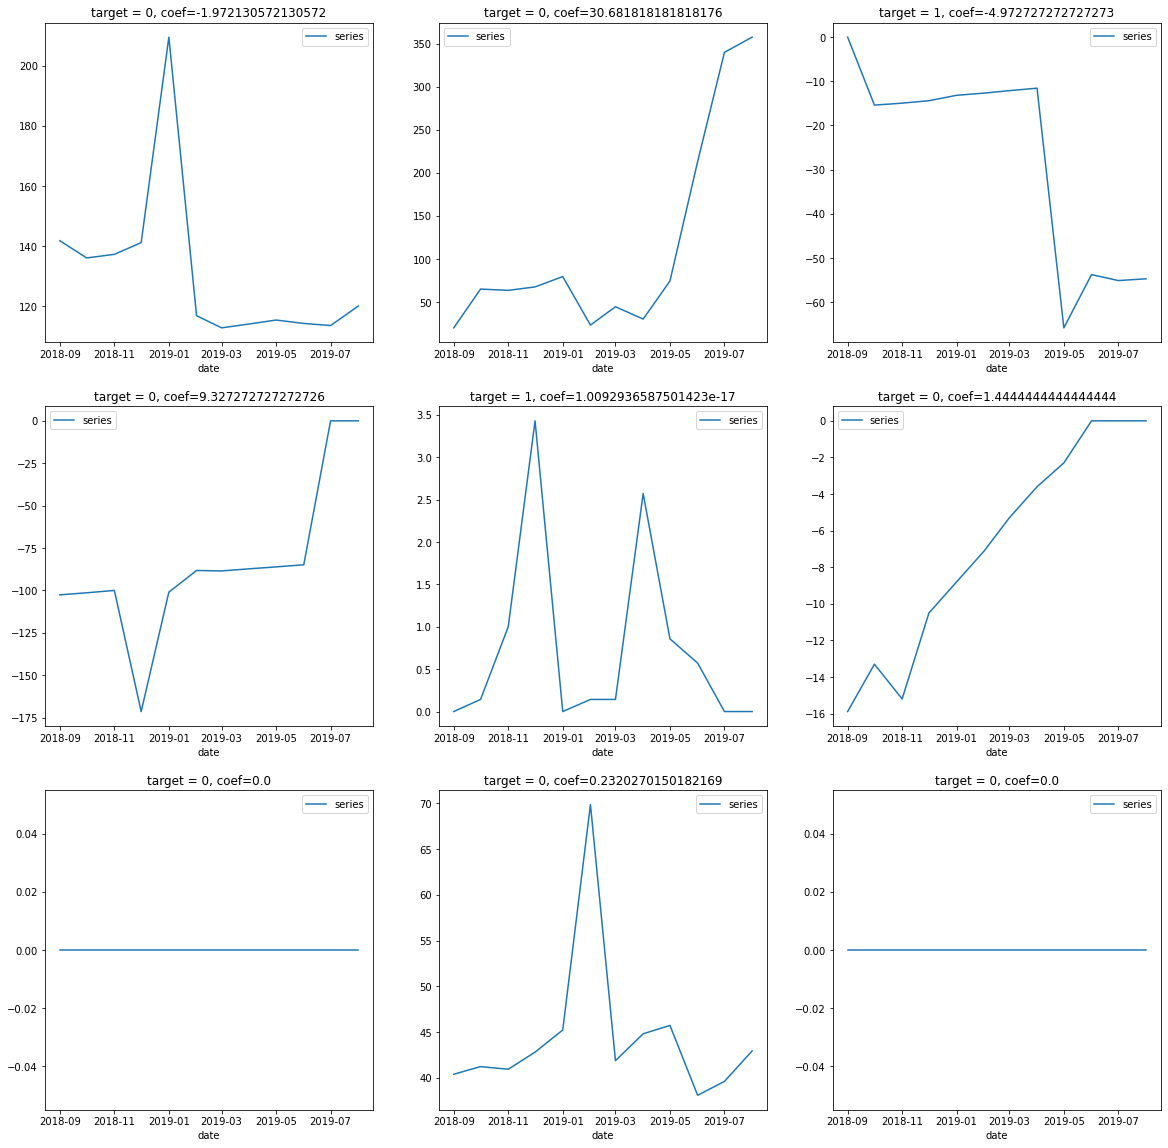

In [ ]:
idx = np.random.choice(balance_df.client_id.values,9)
fig,ax = plt.subplots(3,3,figsize=(20,20))
for i in range(9):
    target = funnel_df.loc[funnel_df.client_id == idx[i], 'sale_flg']
    tmp = get_time_series(balance_df, idx[i], 'min_bal_sum_rur', np.mean).dropna()
#     times = [(date.year*12+date.month - tmp.date.min().year*12 - tmp.date.min().month) for date in tmp.date]
#     mod = sm.OLS(tmp.series, times)
#     res = mod.fit()
    res =  tmp.series.shift(-1).dropna().values - tmp.series.values[:-1]
    sns.lineplot(data=tmp.set_index('date').dropna(),ax=ax[i//3][i%3])
    ax[i//3][i%3].set_title('target = {}, coef={}'.format(target.values[0],res.mean()), fontsize=12)

In [ ]:
mod = sm.OLS(tmp.series, times)
res = mod.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                 series   R-squared (uncentered):                   0.664
Model:                            OLS   Adj. R-squared (uncentered):              0.633
Method:                 Least Squares   F-statistic:                              21.73
Date:                Sat, 17 Apr 2021   Prob (F-statistic):                    0.000692
Time:                        20:06:17   Log-Likelihood:                         -71.828
No. Observations:                  12   AIC:                                      145.7
Df Residuals:                      11   BIC:                                      146.1
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [ ]:
val = funnel_df[['sale_flg','region_cd']].groupby(by='region_cd',as_index=False).mean().values


In [ ]:
val[:,1].sort()
val

array([[2.00000000e+00, 0.00000000e+00],
       [3.00000000e+00, 0.00000000e+00],
       [7.00000000e+00, 0.00000000e+00],
       [1.00000000e+01, 5.71428571e-02],
       [1.10000000e+01, 5.78947368e-02],
       [1.20000000e+01, 6.79611650e-02],
       [1.30000000e+01, 7.14285714e-02],
       [1.40000000e+01, 7.43801653e-02],
       [1.50000000e+01, 7.84313725e-02],
       [1.60000000e+01, 8.28025478e-02],
       [1.80000000e+01, 8.33333333e-02],
       [1.90000000e+01, 8.66721177e-02],
       [2.10000000e+01, 9.09090909e-02],
       [2.20000000e+01, 9.28571429e-02],
       [2.30000000e+01, 1.00000000e-01],
       [2.40000000e+01, 1.01604278e-01],
       [2.50000000e+01, 1.06250000e-01],
       [2.60000000e+01, 1.07382550e-01],
       [2.70000000e+01, 1.14666667e-01],
       [2.80000000e+01, 1.14685315e-01],
       [2.90000000e+01, 1.14814815e-01],
       [3.00000000e+01, 1.15183246e-01],
       [3.10000000e+01, 1.18644068e-01],
       [3.20000000e+01, 1.19617225e-01],
       [3.300000

In [ ]:
balance_df.head(2)

client_id  crncy_cd  eop_bal_sum_rur  min_bal_sum_rur  \
0  7513301859607023584     810.0              0.0              0.0   
1  7513301859607023584     810.0              0.0              0.0   

   max_bal_sum_rur  avg_bal_sum_rur month_end_dt     prod_cat_name  \
0              0.0              0.0   2018-09-30  CURRENT ACCOUNTS   
1              0.0              0.0   2018-09-30  CURRENT ACCOUNTS   

  prod_group_name  
0  Cash on demand  
1  Cash on demand

In [ ]:
trxn_df.txn_comment_1.value_counts()

Payment for goods and services     2546655
Cash withdrawal through an ATM      243562
Cashless transfer                   146586
Payment by card (bank transfer)      52325
Cash deposit by card                 36342
Return of goods / services            8979
Cash withdrawal                       1256
Name: txn_comment_1, dtype: int64